In [1]:

import torch
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
import pandas as pd

import segmentation_models_pytorch as smp

import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import torchmetrics as tm

from config import Config
from dataset import *
from utils import DiceCELossSplitter, plot_img_label_pred, AggregateTestingResultsCallback
from transforms import ImageVisualizer
import wandb

import monai
from monai.transforms import *

from tabulate import tabulate
import matplotlib.pyplot as plt

seed_everything(99, workers=True)


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations
[rank: 0] Seed set to 99


99

In [2]:
# globally set source domains for SVDNA and for dataset preppning
cfg = Config(source_domains = ["Cirrus"])
cfg.batch_size = 8
cfg.epochs = 150

To change experimental setting, check the following:

- source domains in the OCTDatasetPrep class
- Turn on SVDNA in the config file

In [3]:
train_data, val_data, test_data = OCTDatasetPrep(cfg.train_dir,
                                                 source_domains = cfg.source_domains
                                                ).get_datasets(dataset_split=[0.8, 0.2], use_official_testset=True)

train_dataset = MakeDataset(train_data, cfg.train_transforms)
val_dataset = MakeDataset(val_data, cfg.val_transforms)
test_dataset = MakeDataset(test_data, cfg.test_transforms)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=7, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=7, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=7, persistent_workers=True)


Total dataset length:  5261
Training set: 793
Validation set: 198
Test set: 4270


Spectralis: 465 images <br>
Topcon: 952 images <br>
Cirrus: 991 images

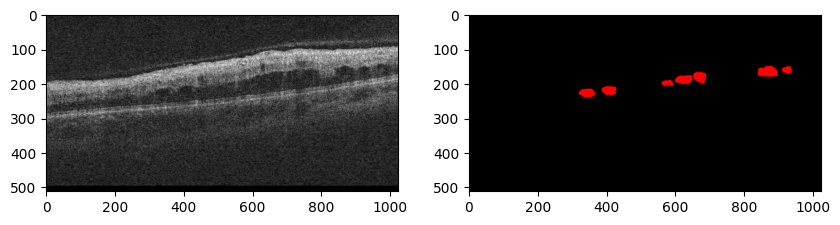

In [4]:
# randomly sample image
random_num = torch.randint(0, len(train_dataset), (1, ))
sample = train_dataset[random_num.item()]

img = sample['img']
mask = sample['masks']

#visualize images in subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img[0], cmap='gray')
ax[1].imshow(mask[1:].permute(1, 2, 0))
plt.show()

In [5]:
from lightning.pytorch.plugins.environments import SLURMEnvironment
SLURMEnvironment.detect = lambda: False

In [6]:
class LitUNetPlusPlus(L.LightningModule):
    def __init__(self, cfg, model, experiment_name):
        super().__init__()
        self.cfg = cfg

        self.save_hyperparameters()
        self.model = model
        self.experiment_name = experiment_name

        #self.loss_func = DiceCELossSplitter(include_background=False, sigmoid=True, lambda_ce=0.5)
        
        self.loss_func1 = monai.losses.GeneralizedDiceLoss(include_background=False, sigmoid=True)
        self.loss_func2 = torch.nn.BCEWithLogitsLoss()

        # several metrics
        avg = 'weighted' # weighted: calculates statistics for each label and computes weighted average using their support
        num_classes = 2
        task = 'binary'

        # validation
        self.val_accuracy = tm.classification.Accuracy(task=task, num_classes=num_classes)
        self.val_f1 = tm.classification.F1Score(task=task, num_classes=num_classes)
        self.val_precision = tm.classification.Precision(task=task, average=avg, num_classes=num_classes)
        self.val_recall = tm.classification.Recall(task=task, average=avg, num_classes=num_classes)
        self.val_specificity = tm.classification.Specificity(task=task, average=avg, num_classes=num_classes)

        # test
        self.test_accuracy = tm.classification.Accuracy(task=task, num_classes=num_classes)
        self.test_f1 = tm.classification.F1Score(task=task, num_classes=num_classes)
        self.test_precision = tm.classification.Precision(task=task, average=avg, num_classes=num_classes)
        self.test_recall = tm.classification.Recall(task=task, average=avg, num_classes=num_classes)
        self.test_specificity = tm.classification.Specificity(task=task, average=avg, num_classes=num_classes)


        self.results = {"Model": [], 
                        "Condition": [], 
                        "Accuracy": [], 
                        "F1": [], 
                        "Precision": [], 
                        "Recall": [], 
                        "Specificity": []}
        
        self.conditions = ["Background", "IRF", "SRD", "PED"]

    def training_step(self, batch, batch_idx):
        inputs = batch['img']
        masks = batch['masks']

        outputs = self.model(inputs)

        dice_loss = self.loss_func1(outputs, masks)
        ce_loss = self.loss_func2(outputs, masks)
        total_loss = dice_loss + 0.5 * ce_loss

        self.log('train_loss_dice', dice_loss.item())
        self.log('train_loss_ce', ce_loss.item())
        self.log('train_loss_total', total_loss.item())

        return total_loss
    
    def validation_step(self, batch, batch_idx):
        inputs = batch['img']
        masks = batch['masks']

        outputs = self.model(inputs)

        dice = self.loss_func1(outputs, masks)
        ce = self.loss_func2(outputs, masks)
        total_loss = dice + 0.5 * ce

        outputs_nobg = outputs[:, 1:, :, :]
        masks_nobg = masks[:, 1:, :, :]

        output_to_save = torch.sigmoid(outputs_nobg[:5])

        # thresholding
        output_to_save[output_to_save > 0.5] = 1
        output_to_save[output_to_save <= 0.5] = 0

        for i in range(output_to_save.shape[0]):
            img_path = os.path.join(cfg.validation_img_path, f"epoch{self.current_epoch}")
            if not os.path.isdir(img_path): os.mkdir(img_path)
            img = os.path.join(img_path, f"b{batch_idx}img{i+1}.png")
            cv2.imwrite(img, output_to_save[i].permute(1, 2, 0).cpu().numpy() * 255)

        self.log('val_loss_total', total_loss)
        self.log('val_loss_dice', dice)
        self.log('val_loss_ce', ce)

        self.log('val_accuracy', self.val_accuracy(outputs_nobg, masks_nobg.long()))
        self.log('val_f1', self.val_f1(outputs_nobg, masks_nobg.long()))
        self.log('val_precision', self.val_precision(outputs_nobg, masks_nobg.long()))
        self.log('val_recall', self.val_recall(outputs_nobg, masks_nobg.long()))
        self.log('val_specificity', self.val_specificity(outputs_nobg, masks_nobg.long()))

        return total_loss
    
    def test_step(self, batch, batch_idx):
        inputs = batch['img']
        masks = batch['masks']

        outputs = self.model(inputs)

        dice = self.loss_func1(outputs, masks)
        ce = self.loss_func2(outputs, masks)
        total_loss = dice + 0.5 * ce

        self.log('test_loss_dice', dice)
        self.log('test_loss_ce', ce)
        self.log('test_loss_total', total_loss)

        torch.sigmoid_(outputs)

        # calculate metrics for each channel and record separately in pandas df
        for channel in range(outputs.shape[1]):

            outputs_channel = outputs[:, channel, :, :]
            masks_channel = masks[:, channel, :, :]

            accuracy = self.test_accuracy(outputs_channel, masks_channel)
            f1 = self.test_f1(outputs_channel, masks_channel)
            precision = self.test_precision(outputs_channel, masks_channel)
            recall = self.test_recall(outputs_channel, masks_channel)
            specificity = self.test_specificity(outputs_channel, masks_channel)

            self.results["Model"].append(self.experiment_name)
            self.results["Condition"].append(self.conditions[channel])
            self.results["Accuracy"].append(accuracy.item())
            self.results["F1"].append(f1.item())
            self.results["Precision"].append(precision.item())
            self.results["Recall"].append(recall.item())
            self.results["Specificity"].append(specificity.item())
        
        return total_loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=self.cfg.lr, weight_decay=self.cfg.weight_decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=self.cfg.factor, patience=self.cfg.patience_lr)
        return {"optimizer": optimizer, 
                "lr_scheduler": {'scheduler': scheduler, 'monitor': 'val_loss_total'}}
    
    def forward(self, x):
        return self.model(x)
    



############################################################################
experiment_name = "cirrus_no-svdna"
    
cfg.model_path = cfg.model_path / experiment_name

wandb_logger = WandbLogger(project="PracticalWorkinAI", name="No SVDNA: Cirrus as source")
############################################################################



model = smp.UnetPlusPlus(**cfg.model_parameters_unetpp)
    
unetpp = LitUNetPlusPlus(cfg, model, experiment_name=experiment_name)



checkpoint_callback = ModelCheckpoint(dirpath=cfg.model_path, 
                                      monitor='val_loss_total', 
                                      mode='min',
                                      filename='cirrus-no-svdna-{epoch:02d}-{val_loss_total:.3f}-{val_precision:.3f}',
                                      every_n_epochs=5,
                                      save_top_k=3,
                                      verbose=True)

early_stopping = EarlyStopping(monitor='val_loss_total', mode='min', patience=cfg.early_stopping_patience)

lr_monitor = LearningRateMonitor(logging_interval='step')

aggregate_testing_results = AggregateTestingResultsCallback()



trainer = L.Trainer(max_epochs=cfg.epochs, 
                    logger=wandb_logger,
                    default_root_dir=Path(cfg.default_root_dir),
                    log_every_n_steps=10,
                    callbacks=[checkpoint_callback, 
                               lr_monitor, 
                               #early_stopping,
                               aggregate_testing_results],
                    deterministic=True)

/home/optima/mhaderer/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(unetpp, train_dataloaders=train_loader, val_dataloaders=val_loader)
trainer.test(unetpp, dataloaders=test_loader)
wandb.finish

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: moritsih. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

   | Name             | Type                | Params
----------------------------------------------------------
0  | model            | UnetPlusPlus        | 41.0 M
1  | loss_func1       | GeneralizedDiceLoss | 0     
2  | loss_func2       | BCEWithLogitsLoss   | 0     
3  | val_accuracy     | BinaryAccuracy      | 0     
4  | val_f1           | BinaryF1Score       | 0     
5  | val_precision    | BinaryPrecision     | 0     
6  | val_recall       | BinaryRecall        | 0     
7  | val_specificity  | BinarySpecificity   | 0     
8  | test_accuracy    | BinaryAccuracy      | 0     
9  | test_f1          | BinaryF1Score       | 0     
10 | test_precision   | BinaryPrecision     | 0     
11 | test_recall      | BinaryRecall        | 0     
12 | test_specificity | BinarySpecificity   | 0     
----------------------------------------------------------
41.0 M    Trainable params
0         Non-trainable params
41.0 M    Total params
163.976   Total 

Sanity Checking: |                                      | 0/? [00:00<?, ?it/s]

Training: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 4, global step 500: 'val_loss_total' reached 0.41523 (best 0.41523), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_no-svdna/cirrus-no-svdna-epoch=04-val_loss_total=0.415-val_precision=0.831.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 9, global step 1000: 'val_loss_total' reached 0.40902 (best 0.40902), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_no-svdna/cirrus-no-svdna-epoch=09-val_loss_total=0.409-val_precision=0.821.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 14, global step 1500: 'val_loss_total' reached 0.35715 (best 0.35715), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_no-svdna/cirrus-no-svdna-epoch=14-val_loss_total=0.357-val_precision=0.819.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 19, global step 2000: 'val_loss_total' reached 0.35932 (best 0.35715), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_no-svdna/cirrus-no-svdna-epoch=19-val_loss_total=0.359-val_precision=0.832.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 24, global step 2500: 'val_loss_total' reached 0.35449 (best 0.35449), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_no-svdna/cirrus-no-svdna-epoch=24-val_loss_total=0.354-val_precision=0.818.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Epoch 29, global step 3000: 'val_loss_total' reached 0.34653 (best 0.34653), saving model to '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/cirrus_no-svdna/cirrus-no-svdna-epoch=29-val_loss_total=0.347-val_precision=0.824.ckpt' as top 3


Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

In [8]:
model_checkpoints = os.listdir(cfg.model_path)
print(model_checkpoints)

['supervised-epoch=89-val_loss_total=0.26-val_precision=0.85.ckpt', 'supervised-epoch=129-val_loss_total=0.26-val_precision=0.85.ckpt', 'supervised-epoch=134-val_loss_total=0.26-val_precision=0.85.ckpt']


In [9]:
# load best checkpoint 

model_eval = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[2])

trainer = L.Trainer(max_epochs=cfg.epochs, 
                    logger=wandb_logger,
                    default_root_dir=Path(cfg.default_root_dir),
                    log_every_n_steps=10,
                    callbacks=[checkpoint_callback, 
                               lr_monitor, 
                               #early_stopping,
                               aggregate_testing_results],
                    deterministic=True)

trainer.test(model_eval, dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: moritsih. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Testing: |                                              | 0/? [00:00<?, ?it/s]

+------------+----------------------+----------------------+---------------------+----------------------+-----------------------+----------------------+---------------------+----------------------+-------------------------+------------------------+-------------------------+
| Condition  | ('Accuracy', 'mean') | ('Accuracy', 'std')  |   ('F1', 'mean')    |    ('F1', 'std')     | ('Precision', 'mean') | ('Precision', 'std') | ('Recall', 'mean')  |  ('Recall', 'std')   | ('Specificity', 'mean') | ('Specificity', 'std') |   ('Model', 'first')    |
+------------+----------------------+----------------------+---------------------+----------------------+-----------------------+----------------------+---------------------+----------------------+-------------------------+------------------------+-------------------------+
| Background |  0.9928210338626462  | 0.013538305146464903 | 0.9962601989842532  | 0.007250328828715766 |  0.9951943073156622   | 0.012354417863427171 | 0.9974217935001359  | 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_loss_ce        │    0.01776251569390297    │
│      test_loss_dice       │    0.18734173476696014    │
│      test_loss_total      │    0.1962229609489441     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_dice': 0.18734173476696014,
  'test_loss_ce': 0.01776251569390297,
  'test_loss_total': 0.1962229609489441}]

## Visualization and results

### Visualize some images and masks

In [7]:
print_some_imgs = False

if print_some_imgs:
    
    transforms_visualize = Compose([cfg.train_transforms, ImageVisualizer(keys=['img', 'label', 'masks'])])
    train_data_raw, _, _ = OCTDatasetPrep(cfg.train_dir, source_domains=cfg.source_domains).get_datasets(use_official_testset=False)
    train_data = MakeDataset(train_data_raw, transforms_visualize)


    for i in range(4):
 
        rand_num = np.random.randint(0, len(train_data))
        sample = train_data[rand_num]
        print(f"Sample {i+1}", 
              "\nImg: ", sample['img'].shape,
              "\nLabel: ", sample['label'].shape,
              "\nMasks: ", sample['masks'].shape)




### Load model and make predictions on random images from validation set

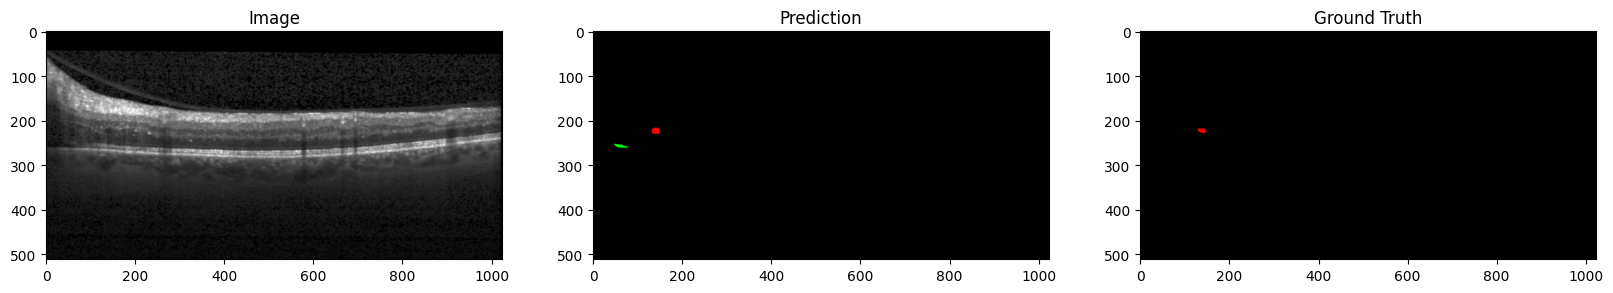

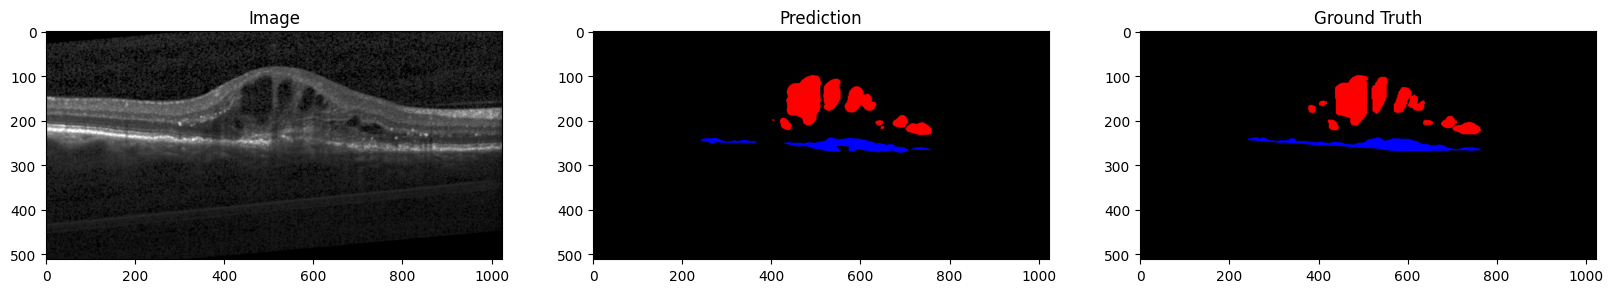

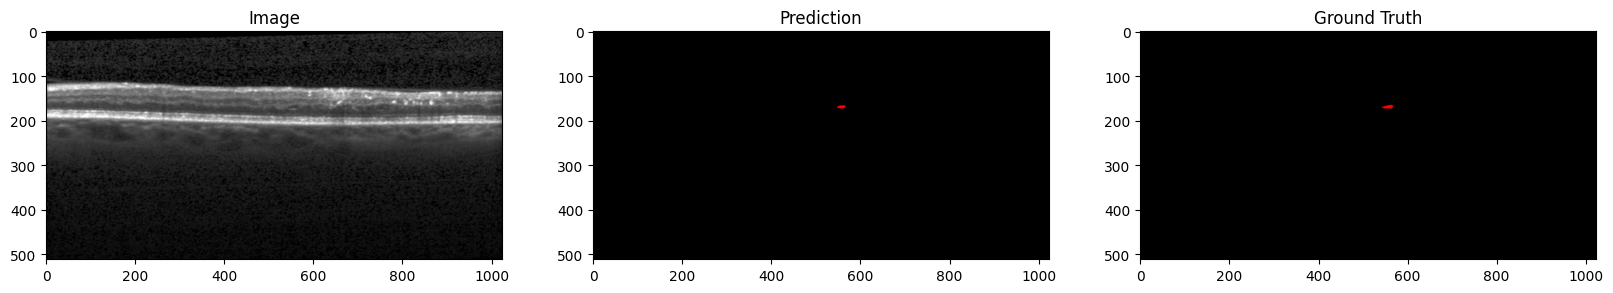

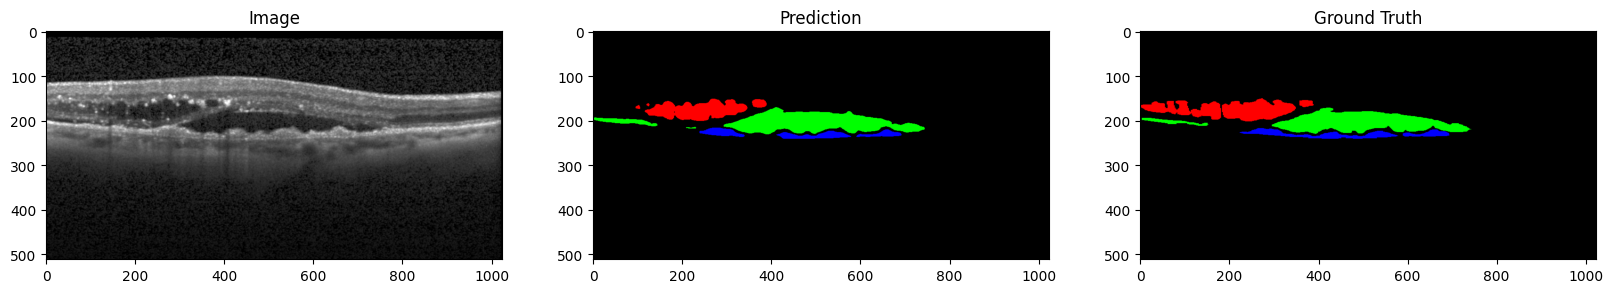

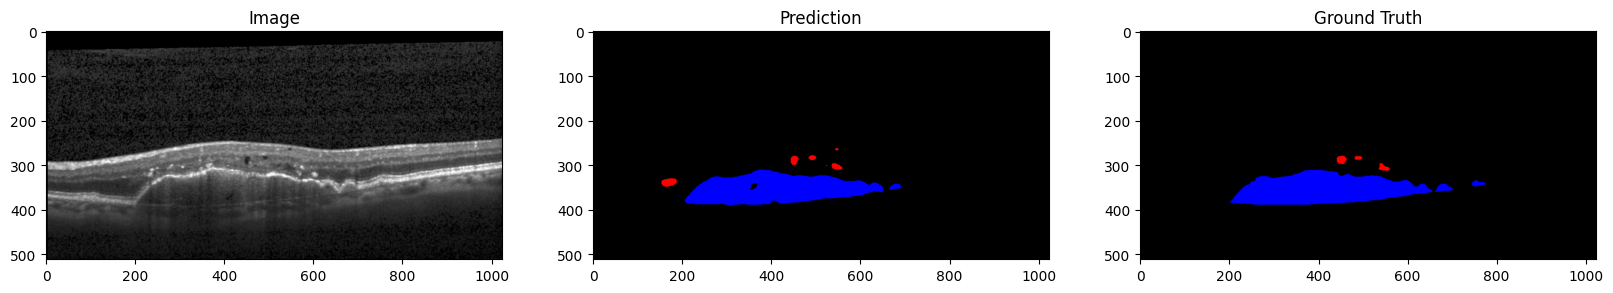

In [10]:
get_predictions = True

if get_predictions:
    model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[1])
    model.eval()

    for i in range(np.min([5, len(val_dataset)])):
        rand_num = np.random.randint(0, len(val_dataset))
        sample = val_dataset[rand_num]

        img = sample['img'].unsqueeze(0).to(cfg.device)
        mask = sample['masks'].unsqueeze(0).to(cfg.device)

        pred = model(img)
        pred = torch.sigmoid(pred)
        
        # thresholding
        pred[pred > 0.5] = 1
        pred[pred <= 0.5] = 0

        plot_img_label_pred(img, pred, mask)

In [10]:

#model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[0])
#table.append(make_results_table(model, val_dataset, cfg.device, cfg, 'ImageNet pretrained'))

#model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[0])
#table.append(make_results_table(model, val_dataset, cfg.device, cfg, 'Supervised training'))

#model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[0])
#table.append(make_results_table(model, val_dataset, cfg.device, cfg, 'SVDNA source: Spectralis'))

#model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[0])
#table.append(make_results_table(model, val_dataset, cfg.device, cfg, 'SVDNA source: Cirrus'))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
# save variable table to text file
#print(tabulate(table, headers='firstrow', tablefmt='github'))
#with open('results.txt', 'w') as f:
#    f.write(tabulate(table, headers='firstrow', tablefmt='latex_raw'))

|             |           | Model   | IRF      | SRF         | PED      |
|-------------|-----------|---------|----------|-------------|----------|
| dice_scores | precision | recall  | accuracy | specificity | f1 score |
| dice_scores | precision | recall  | accuracy | specificity | f1 score |
| dice_scores | precision | recall  | accuracy | specificity | f1 score |
| dice_scores | precision | recall  | accuracy | specificity | f1 score |


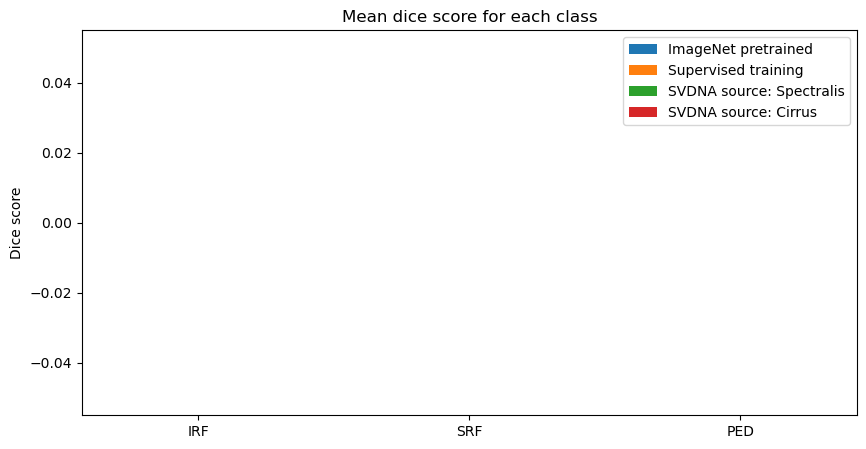

In [9]:
# make a barplot with three bars, one for each class

'''fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(3)
width = 0.15

for i, model in enumerate(table[1:]):
    ax.bar(x + i*width, model[1:], 0.15, label=model[0])

ax.set_xticks(x + width*1.5)
#ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticklabels(['IRF', 'SRF', 'PED'])
ax.set_ylabel('Dice score')
ax.set_title('Mean dice score for each class')

ax.legend()
plt.show()'''